In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM


from scipy import stats
import glob

import random

import warnings  
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:

def trainModel(train):
    """
    Training LSTM model
    input:
        train: training dataframe
    output:
        lstm_model: trainied lstm model
    """
    
    #scaling => translates each feature individually such that it is in the given range on the training set
    #to ensure the unit if our data is not a factor

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_sc = scaler.fit_transform(train)

    #Reshaping the data to work for an LSTM network

    train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)


    for s in range(1,2):
        train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)

    X_train = train_sc_df.dropna().drop('Y', axis=1)
    y_train = train_sc_df.dropna().drop('X_1', axis=1)


    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()


    X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
   

    print('Train shape: ', X_train_lmse.shape)
    

    lstm_model = Sequential()
    lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=10, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

    return lstm_model

def testModel(lstm_model,test):
    """
    Testing the LSTM model
    input:
        test: testing dataframe
        lstm_model: trainied lstm model
    output:
        lstm_pred: inverse scaled dataframe of predicted values
        test_val: inverse scaled dataframe of original values
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_sc = scaler.fit_transform(test)
    X_test = test_sc[:-1]
    y_test = test_sc[1:]
    test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)
    for s in range(1,2):
        test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)


    X_test = test_sc_df.dropna().drop('Y', axis=1)
    y_test = test_sc_df.dropna().drop('X_1', axis=1)

    X_test = X_test.as_matrix()
    y_test = y_test.as_matrix()
    
    X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    #print(X_test_lmse)
    y_pred_test_lstm = lstm_model.predict(X_test_lmse)
    
    #print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
    
    lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
   
    print('LSTM: %f'%lstm_test_mse)
    
    #inversing the scaling
    lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
    test_val = scaler.inverse_transform(y_test)
    
    return lstm_pred, test_val

    
def trainingData():
    """
    Reading Train Data 
    input:
        none
    output:
        data: training dataframe with index => DisplayTime value => GlucoseValues
    """
    
    cgmdata = pd.read_csv("~/Desktop/NCSA_genomics/Data/CGManalyzer.csv") #use your path
    cgmdata['timeStamp'] = cgmdata['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    cgmdata['time_gap'] = cgmdata['timeStamp']- cgmdata['timeStamp'].shift(1)
    for Id, df in cgmdata.groupby('ID'):
        print("==============================================================")
        print("Subject ID: "+str(Id))
        #temp = meta[meta["ID"]==subjectId]
        #print("Status: "+str(temp["status"].values[0]))
        #print(df)
        #print(df['GlucoseValue'].describe())
        #100*(len(df[df["time_gap"]>str("00:05:00")])/df['GlucoseValue'].count())
        print("Length of the readings: "+str(df['glucoseValue'].count()))
        print("Max. Glucose value: "+str(df['glucoseValue'].max()))
        print("Min. Glucose value: "+str(df['glucoseValue'].min()))
        print("Mean Glucose value: "+str(round(df['glucoseValue'].mean(),3)))
        print("Missing Values: "+str(len(df[df["time_gap"]>str("00:03:00")])))
        print("Percent of missing values: "+str(round(100*(len(df[df["time_gap"]>str("00:03:00")])/df['glucoseValue'].count()),2))+"%")
        #print(df['DisplayTime'])
        print()
        
    cgmdata.drop(['ID','time_gap'],axis=1, inplace=True)
    cgmdata = cgmdata.set_index(['timeStamp'], drop=True)
    
    return cgmdata

def testingData():
    """
    Reading Test Data 
    input:
        none
    output:
        data: testing dataframe with index => DisplayTime value => GlucoseValues
    """
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/data_hall.txt", sep="\t")

    diabetic = data[data['subjectId'] == "1636-69-091"]
    prediabetic = data[data['subjectId'] == "1636-69-114"]
    non_diabetic = data[data['subjectId'] == "1636-69-028"]
    
    diabetic.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    prediabetic.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    non_diabetic.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    
    
    diabetic['Display Time'] = diabetic['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    diabetic = diabetic.set_index(['Display Time'], drop=True)

    prediabetic['Display Time'] = prediabetic['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    prediabetic = prediabetic.set_index(['Display Time'], drop=True)

    non_diabetic['Display Time'] = non_diabetic['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    non_diabetic = non_diabetic.set_index(['Display Time'], drop=True)

    return diabetic, prediabetic, non_diabetic
    
    

def plot(lstm_pred, test_val):
    #plotting true values and lstm predicted values
    #these are original values
    
    plt.figure(figsize=(20, 8))
    
    
    plt.plot(lstm_pred, label='LSTM', color='red', linewidth=2)
    plt.plot(test_val, label='True', color='#2280f2', linewidth=2.5)
    
    plt.title("LSTM's Prediction")
    
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.legend()
    plt.show();
    
def getMetrics(lstm_pred, test_val):
    #IOA
    ioa_val = index_agreement(lstm_pred,test_val)
    print("Index of Agreement is: " + str(round(ioa_val,3)))

    #MAE
    mae_val = mae(lstm_pred,test_val)
    print("Mean Absolute Error is: " + str(mae_val))

    #RMSE
    rmse_val = rmse(lstm_pred,test_val)
    print("Root Mean Squared Error is: " + str(round(rmse_val,3)))
    
    #MAD
    mad_val = mad(lstm_pred)
    print("Mean Absolute Difference is: " + str(mad_val))
    
    #FB
    fb_val = fracBias(lstm_pred,test_val)
    print("Fractional Bias is: " + str(round(fb_val,3)))
    
    #MAPE
    mape_val = mape(lstm_pred,test_val)
    print("Mean Absolute Percentage Error is: " + str(round(mape_val)))
    
def index_agreement(s,o):
    """
    index of agreement
    input:
        s: prediceted
        o: original
    output:
        ia: index of agreement
    """
    
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    
    return ia

def rmse(s,o):
    """
    Root Mean Squared Error
    input:
        s: prediceted
        o: original
    output:
        rmses: root mean squared error
    """
    return np.sqrt(np.mean((s-o)**2))

def mae(s,o):
    """
    Mean Absolute Error
    input:
        s: prediceted
        o: original
    output:
        maes: mean absolute error
    """
    return np.mean(abs(s-o))

def mad(s):
    """
    Mean Absolute Difference
    input:
        s: prediceted
    output:
        mad: mean absolute error
    """
  
    return stats.median_absolute_deviation(s)
    


def mape(y_pred,y_true):
    """
    Mean Absolute Percentage error
    input:
        y_pred: prediceted
        y_true: original
    output:
        mape: Mean Absolute Percentage error
    """

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def fracBias(s,o):
    """
    Fractional Bias
    input:
        s: prediceted
        o: original
    output:
        fracBias: Fractional Bias
    """
    
    return np.mean(np.abs((o - s) / ((o + s)/2)))



def createGap(data):
    """
    Creating Gap indexes
    input:
        data: dataframe with index => DisplayTime value => GlucoseValues
    output:
        start: seed
        end: seed+gap (gap=300)
    """
    
    seed = random.randint(500,len(data)-500)
    
    return seed,seed+500


def faultyData(df,start,end):
    """
    Creating a Gap
    input:
        start: seed
        end: seed+gap (gap=300)
    output:
        df: dataframe with index => DisplayTime value => GlucoseValues and a gap from start to end (inputs)
    """
    
    #df = readData()
    for i in range(start,end):
        df['GlucoseValue'][i]=0
    
    return df

def summaryPlot(p1,t1,p2,t2,p3,t3):
    
    plt.figure(figsize=(20, 20))

    plt.subplot(3, 1, 1)
    plt.plot(p1, label='LSTM', color='red', linewidth=2)
    plt.plot(t1, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Diabetic - 1")
    plt.legend()
    
    
    plt.subplot(3, 1, 2)
    plt.plot(p2, label='LSTM', color='red', linewidth=2)
    plt.plot(t2, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Prediabetic")
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.plot(p3, label='LSTM', color='red', linewidth=2)
    plt.plot(t3, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Nondiabetic")
    plt.legend()
    
    
    plt.show();
    


In [3]:
train_set = trainingData()
#print(train_set)

Subject ID: ID01
Length of the readings: 2510
Max. Glucose value: 16.187
Min. Glucose value: 3.077
Mean Glucose value: 7.301
Missing Values: 0
Percent of missing values: 0.0%

Subject ID: ID02
Length of the readings: 3016
Max. Glucose value: 9.498693
Min. Glucose value: 0.77895504
Mean Glucose value: 5.295
Missing Values: 0
Percent of missing values: 0.0%

Subject ID: ID03
Length of the readings: 3097
Max. Glucose value: 28.261927000000004
Min. Glucose value: 3.4027524
Mean Glucose value: 11.548
Missing Values: 0
Percent of missing values: 0.0%

Subject ID: ID11
Length of the readings: 2205
Max. Glucose value: 17.6
Min. Glucose value: 5.3
Mean Glucose value: 9.652
Missing Values: 1
Percent of missing values: 0.05%

Subject ID: ID12
Length of the readings: 2980
Max. Glucose value: 15.1
Min. Glucose value: 5.2
Mean Glucose value: 9.751
Missing Values: 0
Percent of missing values: 0.0%

Subject ID: ID13
Length of the readings: 1681
Max. Glucose value: 13.67
Min. Glucose value: 5.263999999

In [4]:
lstmModel = trainModel(train_set)

Train shape:  (29188, 1, 1)
Epoch 1/10
29188/29188 [==============================] - 59s 2ms/step - loss: 2.8320e-04
Epoch 2/10
29188/29188 [==============================] - 59s 2ms/step - loss: 2.1156e-04
Epoch 3/10
29188/29188 [==============================] - 58s 2ms/step - loss: 2.0228e-04
Epoch 4/10
29188/29188 [==============================] - 63s 2ms/step - loss: 2.0074e-04
Epoch 5/10
29188/29188 [==============================] - 86s 3ms/step - loss: 2.0305e-04
Epoch 6/10
29188/29188 [==============================] - 89s 3ms/step - loss: 2.0745e-04
Epoch 00006: early stopping


In [5]:
diabetic , prediabetic, non_diabetic = testingData()
diabetic2 , prediabetic2, non_diabetic2 = testingData()
#print(diabetic)
start, end = createGap(diabetic)
gap_tester_diabetic = diabetic.iloc[start:end+2]
diabetic2 = faultyData(diabetic2,start,end+1)

501/501 [==============================] - 1s 1ms/step
LSTM: 0.016297
943 1443
1803


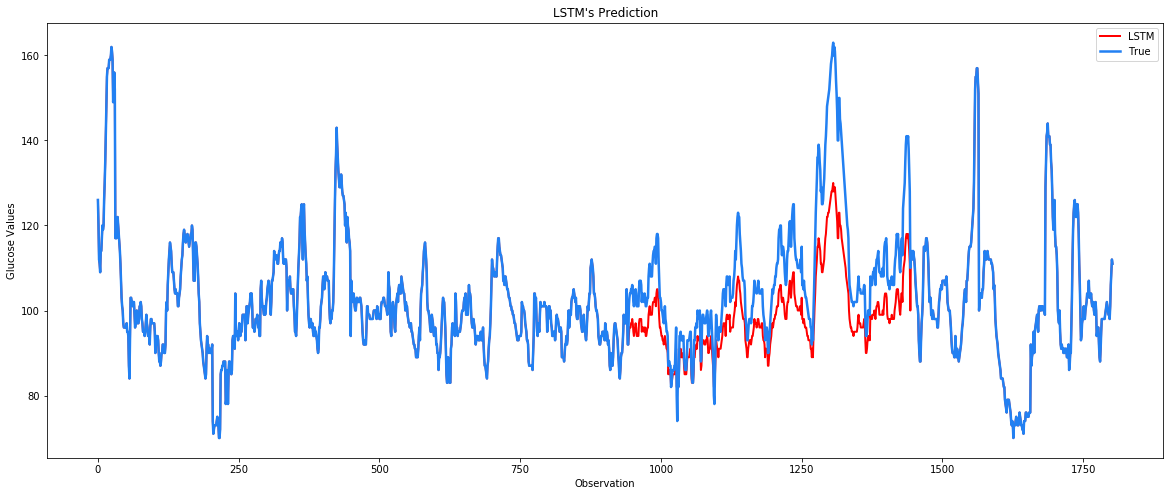

Index of Agreement is: 0.824
Mean Absolute Error is: 9.31309961558816
Root Mean Squared Error is: 11.362
Mean Absolute Difference is: [6.548689]
Fractional Bias is: 0.085
Mean Absolute Percentage Error is: 8.0


In [6]:
predicted1, true1 = testModel(lstmModel,gap_tester_diabetic)
print(start,end)
print(len(diabetic2))
for i in range(0,501):
    diabetic2['GlucoseValue'][start+i] = predicted1[i][0]
    
plot(diabetic2['GlucoseValue'].tolist(),diabetic['GlucoseValue'].tolist())

getMetrics(predicted1,true1)

diabetic2.to_csv("~/Desktop/NCSA_genomics/Data/outputs/HALL_diabetic_imputed.csv")

In [7]:
start, end = createGap(prediabetic)
gap_tester_prediabetic = prediabetic.iloc[start:end+2]
prediabetic2 = faultyData(prediabetic2,start,end+1)


501/501 [==============================] - 1s 1ms/step
LSTM: 0.026355


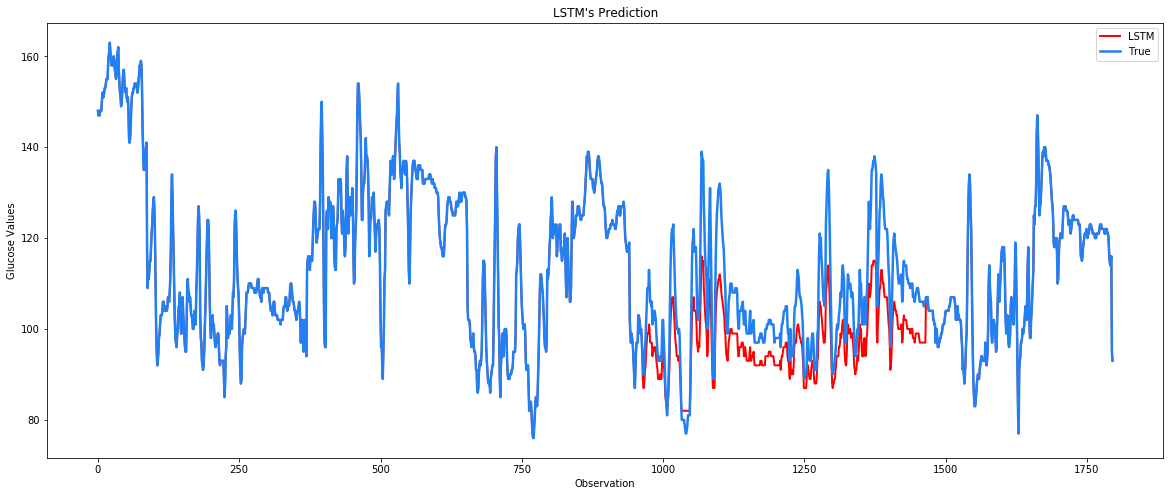

Index of Agreement is: 0.778
Mean Absolute Error is: 8.585946911109422
Root Mean Squared Error is: 10.065
Mean Absolute Difference is: [6.130588]
Fractional Bias is: 0.081
Mean Absolute Percentage Error is: 8.0


In [8]:
predicted2, true2 = testModel(lstmModel,gap_tester_prediabetic)
for i in range(0,501):
    prediabetic2['GlucoseValue'][start+i] = predicted2[i][0]
    
plot(prediabetic2['GlucoseValue'].tolist(),prediabetic['GlucoseValue'].tolist())
getMetrics(predicted2,true2)
prediabetic2.to_csv("~/Desktop/NCSA_genomics/Data/outputs/HALL_prediabetic_imputed.csv")

In [9]:
start, end = createGap(non_diabetic)
gap_tester_non_diabetic = non_diabetic.iloc[start:end+2]
non_diabetic2 = faultyData(non_diabetic2,start,end+1)

501/501 [==============================] - 1s 1ms/step
LSTM: 0.013915


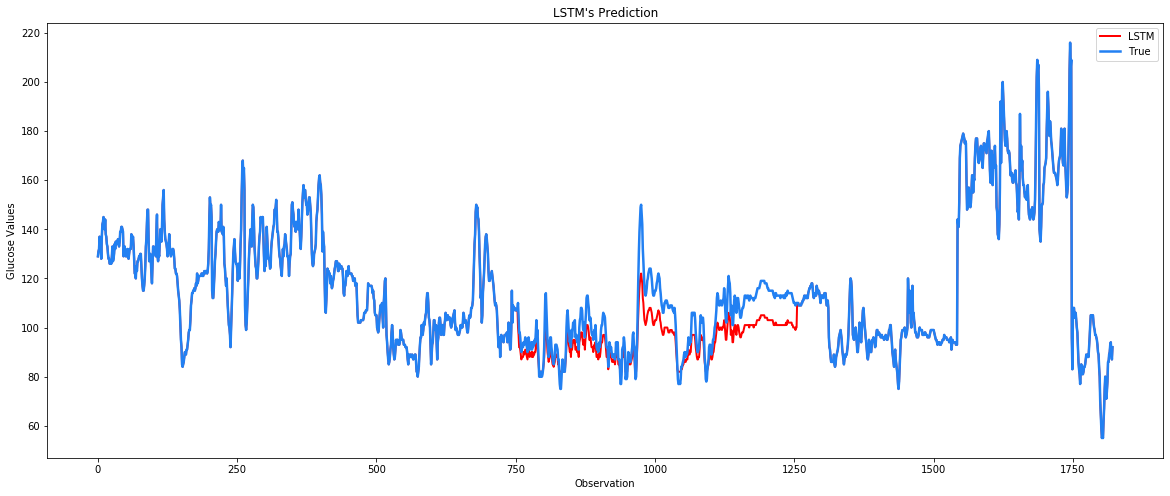

Index of Agreement is: 0.837
Mean Absolute Error is: 7.391860002529121
Root Mean Squared Error is: 8.847
Mean Absolute Difference is: [8.959486]
Fractional Bias is: 0.072
Mean Absolute Percentage Error is: 7.0


In [10]:
predicted3, true3 = testModel(lstmModel,gap_tester_non_diabetic)
for i in range(0,501):
    non_diabetic2['GlucoseValue'][start+i] = predicted3[i][0]
    
plot(non_diabetic2['GlucoseValue'].tolist(),non_diabetic['GlucoseValue'].tolist())

getMetrics(predicted3,true3)
non_diabetic2.to_csv("~/Desktop/NCSA_genomics/Data/outputs/HALL_nondiabetic_imputed.csv")

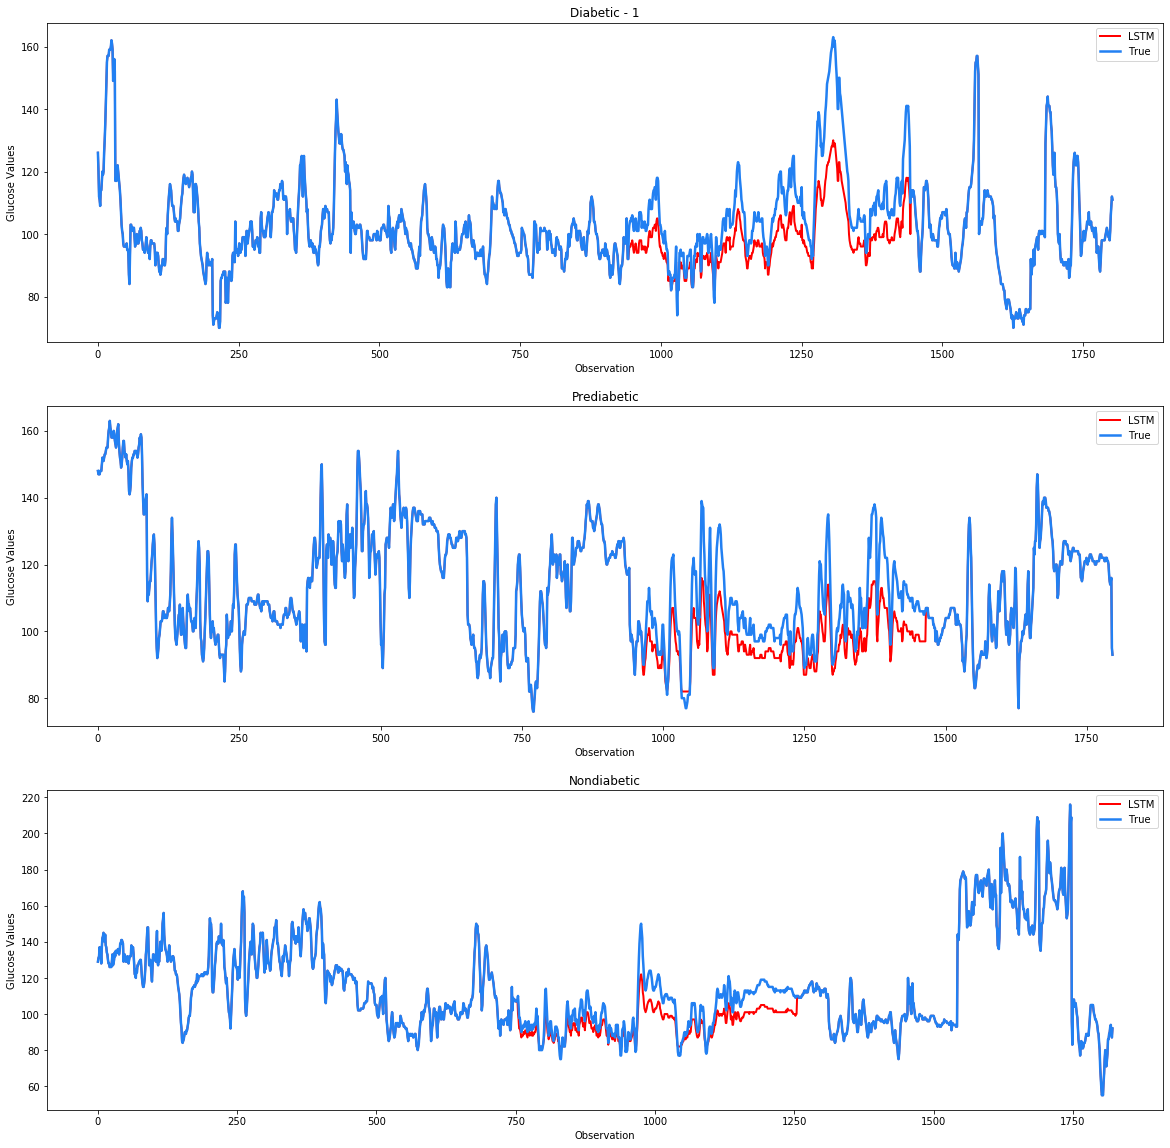

In [11]:
summaryPlot(diabetic2['GlucoseValue'].tolist(),diabetic['GlucoseValue'].tolist(),prediabetic2['GlucoseValue'].tolist(),prediabetic['GlucoseValue'].tolist(),non_diabetic2['GlucoseValue'].tolist(),non_diabetic['GlucoseValue'].tolist())